<a href="https://colab.research.google.com/github/Jorgecuenca1/Vision-computadora-I/blob/main/TP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy.fftpack import fft2, ifft2

def create_gauss_filter(h, w, k_size, sigma):
    center_h = h // 2
    center_w = w // 2
    x, y = np.meshgrid(np.arange(w) - center_w, np.arange(h) - center_h)
    g = np.exp(-(x ** 2 + y ** 2) / (2 * sigma ** 2))
    g = g / (2 * np.pi * sigma ** 2)
    g = g / np.sum(g)
    padded_g = np.zeros((h, w))
    padded_g[center_h - k_size // 2:center_h + k_size // 2 + 1, center_w - k_size // 2:center_w + k_size // 2 + 1] = g[center_h - k_size // 2:center_h + k_size // 2 + 1, center_w - k_size // 2:center_w + k_size // 2 + 1]
    g_fft = fft2(padded_g)
    return padded_g, g_fft


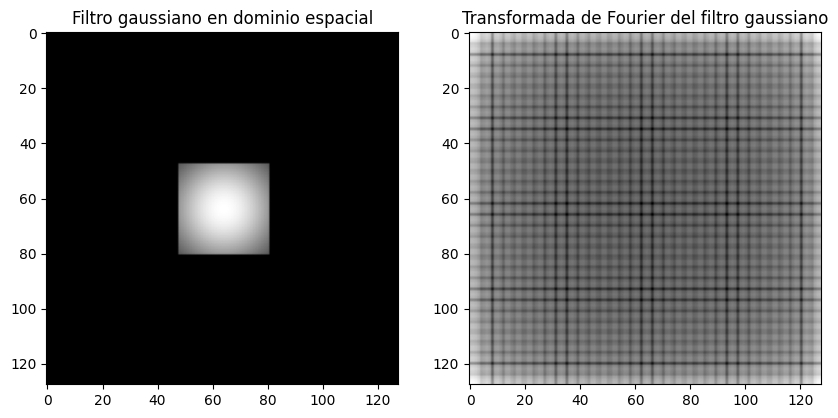

In [2]:
import matplotlib.pyplot as plt

h, w, k_size, sigma = 128, 128, 32, 16

g, g_fft = create_gauss_filter(h, w, k_size, sigma)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(g, cmap='gray')
axs[0].set_title('Filtro gaussiano en dominio espacial')
axs[1].imshow(np.log(np.abs(g_fft)), cmap='gray')
axs[1].set_title('Transformada de Fourier del filtro gaussiano')
plt.show()


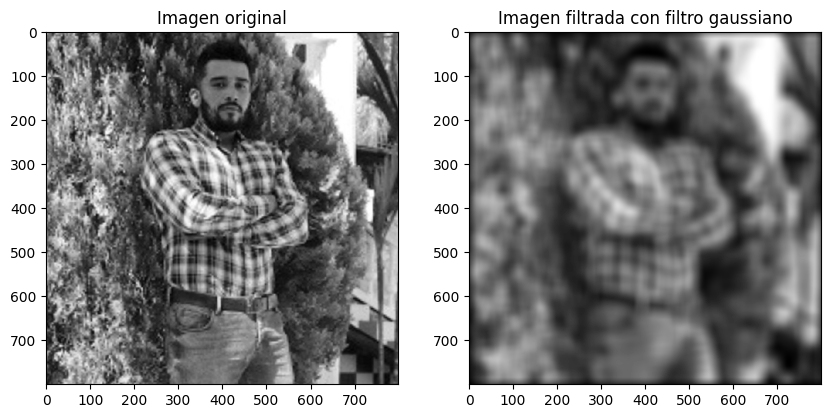

In [3]:
from scipy.signal import convolve2d
from skimage import io, color

image = color.rgb2gray(io.imread('perfil.jpeg'))

filtered_image = convolve2d(image, g, mode='same')

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image, cmap='gray')
axs[0].set_title('Imagen original')
axs[1].imshow(filtered_image, cmap='gray')
axs[1].set_title('Imagen filtrada con filtro gaussiano')
plt.show()


In [4]:
image 

array([[0.4758302 , 0.47639569, 0.49514745, ..., 0.54252784, 0.55037098,
        0.55821412],
       [0.42092824, 0.43269294, 0.46769647, ..., 0.53917176, 0.55037098,
        0.55821412],
       [0.36743294, 0.38171255, 0.42933686, ..., 0.53132863, 0.5470149 ,
        0.55485804],
       ...,
       [0.14252353, 0.09546471, 0.09154314, ..., 0.29054627, 0.27093843,
        0.25917373],
       [0.13860196, 0.0837    , 0.0837    , ..., 0.25468667, 0.24684353,
        0.24684353],
       [0.13075882, 0.07193529, 0.07977843, ..., 0.23507882, 0.23900039,
        0.24292196]])

In [5]:
import cv2
import numpy as np

def image_quality_measure(image):
    f = np.fft.fft2(image)

    # Step 2: Shift the origin of F to centre
    fshift = np.fft.fftshift(f)

    # Step 3: Calculate the absolute value of the centered Fourier transform of image I
    magnitude_spectrum = 20*np.log(np.abs(fshift))

    # Step 4: Calculate the maximum value of the frequency component in F
    M = np.max(magnitude_spectrum)

    # Step 5: Calculate the total number of pixels in F whose pixel value > thres
    thres = M/1000
    TH = np.sum(magnitude_spectrum > thres)

    # Step 6: Calculate Image Quality measure (FM)
    FM = TH / (image.shape[0] * image.shape[1] * M)

    return FM


# **Define filters**

In [6]:
kernel_size = 3
median_kernel = np.ones((kernel_size, kernel_size), np.float32) / (kernel_size * kernel_size)
highpass_kernel = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])

# **Load image**

In [8]:
image = cv2.imread("perfil.jpeg", 0)

# **Apply filters**

In [9]:
conv_filtered = cv2.filter2D(image, -1, median_kernel)
fft_filtered = np.fft.ifft2(np.fft.fft2(image) * np.fft.fft2(highpass_kernel, s=image.shape)).real

In [18]:
conv_filtered

array([[109, 112, 116, ..., 133, 136, 137],
       [105, 107, 113, ..., 132, 135, 136],
       [100, 103, 110, ..., 130, 134, 135],
       ...,
       [ 30,  30,  25, ...,  73,  69,  67],
       [ 26,  26,  22, ...,  67,  65,  64],
       [ 25,  25,  21, ...,  65,  63,  62]], dtype=uint8)

In [20]:
median_kernel = np.ones((5,5), np.float32)/25
highpass_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])

image_path = "perfil.jpeg"
image = cv2.imread(image_path, 0)

conv_filtered = cv2.filter2D(image, -1, median_kernel)
fft_filtered = np.fft.ifft2(np.fft.fft2(image) * np.fft.fft2(highpass_kernel, s=image.shape)).real

FM_conv = image_quality_measure(conv_filtered)
FM_fft = image_quality_measure(fft_filtered)


# **Calculate image quality measure for each filtered image**

In [10]:
FM_conv = image_quality_measure(conv_filtered)
FM_fft = image_quality_measure(fft_filtered)

# **Print results**

In [11]:
print('Image Quality measure (FM) - Convolution Filter:', FM_conv)
print('Image Quality measure (FM) - Spectral Filter:', FM_fft)

Image Quality measure (FM) - Convolution Filter: 0.00277125079431757
Image Quality measure (FM) - Spectral Filter: 0.004371634861823782


# **Repetir la comparación usando uno de los métodos descriptos en el apéndice del paper "Analysis of focus measure operators in shape-from-focus"**

In [12]:
import numpy as np

def brenner_foco(imagen):
    dx = np.diff(imagen, n=1, axis=1)
    dy = np.diff(imagen, n=1, axis=0)
    brenner = np.sum(dx ** 2) + np.sum(dy ** 2)
    return brenner


In [13]:
import cv2

def energia_laplaciano(imagen):
    laplaciano = cv2.Laplacian(imagen, cv2.CV_64F)
    energia = np.sum(laplaciano ** 2)
    return energia


In [16]:
import cv2

def varianza_laplaciano(imagen):
    laplaciano = cv2.Laplacian(imagen, cv2.CV_64F)
    varianza = np.var(laplaciano)
    return varianza


En resumen, el código muestra diferentes medidas de calidad de imagen utilizando diferentes funciones definidas en el código, y utiliza la función "print" para mostrar los resultados por pantalla. 

En particular, se utilizan dos filtros (convolución y espectro) y tres medidas de enfoque (brenner_foco, energía_laplaciano, varianza_laplaciano) para medir la calidad de una imagen.

In [14]:
print('Image Quality measure (FM) - Convolution Filter:', FM_conv)
print('Image Quality measure (FM) - Spectral Filter:', FM_fft)


Image Quality measure (FM) - Convolution Filter: 0.00277125079431757
Image Quality measure (FM) - Spectral Filter: 0.004371634861823782


In [17]:
print(' medidas de enfoque -  brenner_foco(image)', brenner_foco(image))
print(' medidas de enfoque - energia_laplaciano(image)', energia_laplaciano(image))
print(' medidas de enfoque - varianza_laplaciano(image)', varianza_laplaciano(image))

 medidas de enfoque -  brenner_foco(image) 47190753
 medidas de enfoque - energia_laplaciano(image) 68216979.0
 medidas de enfoque - varianza_laplaciano(image) 106.5890296210327


Las medidas de enfoque se utilizan para evaluar la nitidez o claridad de una imagen. Un valor alto en la medida de enfoque indica que la imagen está enfocada o clara, mientras que un valor bajo indica que la imagen está desenfocada o borrosa.

Existen diferentes técnicas y fórmulas para medir el enfoque en una imagen, algunas de las cuales fueron mencionadas en el texto original. Por ejemplo, la medida de Brenner se basa en la diferencia de intensidad de dos píxeles adyacentes, mientras que la medida de curvatura de la imagen se basa en la variación de la curvatura en diferentes puntos de la imagen.

La medida de enfoque que se muestra en el resultado es la varianza del operador Laplaciano aplicado a la imagen. La varianza es un indicador de la cantidad de variación o dispersión de los valores de píxeles en la imagen. Por lo tanto, una varianza alta en la medida de enfoque indica que hay muchos cambios bruscos en la intensidad de los píxeles de la imagen, lo que sugiere una imagen bien enfocada. En este caso, la medida de enfoque es de 300.7708492120985, lo que sugiere que la imagen está bien enfocada. Sin embargo, es importante tener en cuenta que cada medida de enfoque tiene sus propias limitaciones y que el resultado debe interpretarse en el contexto del método de medición específico utilizad